# 教師なし学習（クラスタリング）

In [34]:
import numpyro
import numpyro.distributions as dist

import arviz as az

import jax
import jax.numpy as jnp

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(3) #使用CPUの数

In [67]:
#クラス分けさせるデータ
mu = [1, 5, 9]
sd = [1, 1, 1]

x0 = np.random.normal(mu[0], sd[0], 100)
x1 = np.random.normal(mu[1], sd[1], 100)
x2 = np.random.normal(mu[2], sd[2], 100)

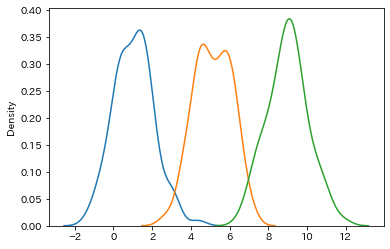

In [57]:
sns.kdeplot(x0, color="C0")
sns.kdeplot(x1, color="C1")
sns.kdeplot(x2, color="C2");

In [58]:
x_obs= np.concatenate([x0, x1, x2])
x_obs = jnp.array(x_obs)

潜在変数$s_n$は1ofKベクトルでn番目のデータがk番目のクラスに属する事を表現する

すなわち$p(s_n)$は1からK番目のクラスタそれぞれに属する確率を吐く分布でパラメタ$\pi$に支配されている

以下のように同時分布を書き下す（グラフィカルモデル省略）
$$
p(X, S, \Theta, \pi) = \prod^N_{n=1} p(x_n|s_n,\Theta)p(s_n|\pi)\cdot\prod^K_{k=1}p(\theta_k) \cdot p(\pi)
$$

潜在変数の分布を
$$
p(s_n|\pi) = Cat(s_n|\pi) = \prod^K_{k=1} \pi^{s_{n,k}}_k \\
$$
混合ガウス分布を
$$
p(x_n|s_n,\Theta) = \prod^K_{k=1}\mathcal{N}(x_n|\mu_k, \sigma^2_k)^{s_{n,k}}
$$
とかく、ただし、$\Theta$はガウス分布のパラメタ集合

以下はパラメタの事前分布
$$
p(\theta) \\
p(\pi)
$$

In [77]:
def  model(K, x_obs):
    N = len(x_obs) #クラスタ分けする集団のサイズ
    
    #潜在変数のパラメタのπ事前分布
    p = numpyro.sample("p", dist.Dirichlet(jnp.ones(K)))
    
    #確率10%以下の少数集団が作られないように縛る
    numpyro.factor("cond_cluster_size", jnp.where(jnp.min(p) > 0.1, 0, -jnp.inf))

    #下２つ合わせてθの事前分布
    mu = numpyro.sample("mu", dist.Normal(0, 10), sample_shape=(K,))#ガウス分布の平均パラメタの事前分布
    sd = numpyro.sample("sd", dist.HalfNormal(5), sample_shape=(K,))#ガウス分布の分散パラメタの事前分布
    
    # 順序の冗長性を縛る
    order = jnp.all(jnp.diff(mu) > 0)
    numpyro.factor("cond_cluster_order", jnp.where(order, 0, -jnp.inf))
    
    s = numpyro.sample("cluster_index", dist.Categorical(p), sample_shape=(N,)) #潜在変数s
    numpyro.sample("obs", dist.Normal(mu[s], sd[s]), obs=x_obs) #観測変数xの尤度分布

In [78]:
nuts = numpyro.infer.NUTS(model, target_accept_prob=0.95)
kernel = numpyro.infer.DiscreteHMCGibbs(nuts) #離散変数の混ざったMCMC

mcmc = numpyro.infer.MCMC(kernel, num_warmup=5000, num_samples=1000, num_chains=3)
mcmc.run(jax.random.PRNGKey(0), 3, x_obs) #3より大きいクラスタサイズを指定すると"cond_cluster_size"の制約でエラーになる（Kのサイズは分かってなくてもよい）
trace = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

/tmp/ipykernel_21733/4134961448.py:4: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(kernel, num_warmup=5000, num_samples=1000, num_chains=3)
sample: 100%|█| 6000/6000 [00:17<00:00, 351.69it/s, 15 steps of size 3.04e-02. a
sample: 100%|█| 6000/6000 [00:12<00:00, 472.51it/s, 15 steps of size 2.41e-01. a
sample: 100%|█| 6000/6000 [00:12<00:00, 473.33it/s, 7 steps of size 2.55e-01. ac


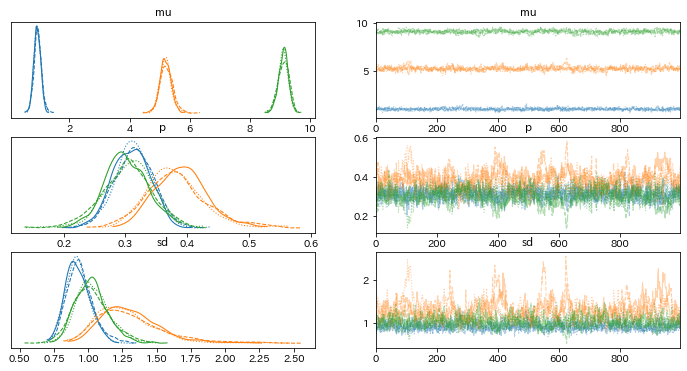

In [79]:
az.plot_trace(idata, var_names=["mu", "p", "sd"]);

In [80]:
az.summary(idata, var_names=["mu", "p", "sd"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],0.938,0.121,0.701,1.154,0.005,0.004,554.0,874.0,1.00
mu[1],5.207,0.204,4.849,5.610,0.011,0.008,416.0,317.0,1.01
mu[2],9.111,0.172,8.784,9.435,0.010,0.007,315.0,565.0,1.01
p[0],0.312,0.031,0.255,0.370,0.001,0.001,696.0,1211.0,1.00
p[1],0.385,0.047,0.297,0.474,0.004,0.003,183.0,198.0,1.01
p[2],0.303,0.039,0.234,0.381,0.003,0.002,207.0,183.0,1.01
sd[0],0.930,0.092,0.763,1.101,0.003,0.002,733.0,936.0,1.01
sd[1],1.302,0.241,0.903,1.742,0.019,0.014,192.0,197.0,1.01
sd[2],1.027,0.127,0.796,1.277,0.007,0.005,332.0,421.0,1.01


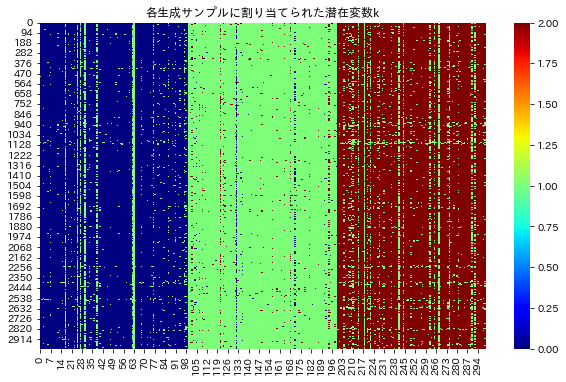

In [81]:
fig = plt.figure(figsize=(10, 6))

sns.heatmap(trace["cluster_index"], cmap="jet")

plt.title("各生成サンプルに割り当てられた潜在変数k");

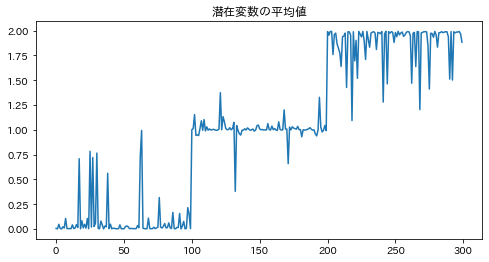

In [82]:
fig = plt.figure(figsize=(8, 4))
plt.plot(trace["cluster_index"].mean(axis=0))
plt.title("潜在変数の平均値");